In [228]:
using Distributed
procs_to_use = 16
if nprocs() <= procs_to_use
    addprocs(procs_to_use-nprocs())
end
;

In [257]:
@everywhere using QuantumStates, OpticalBlochEquations, DifferentialEquations, UnitsToValue, StructArrays, StaticArrays, 
    Parameters

@everywhere import Distributions: Normal, Geometric, Exponential
@everywhere using ProgressMeter, Plots
;

In [258]:
@everywhere include("helper_functions.jl")
include("define_CaOH_molecular_structure.jl")
include("define_sim_params.jl")
include("define_blueMOT_1plus2.jl")
include("define_blueMOT_1plus1.jl")
;

In [259]:
prob_func!(prob_1plus2)
@time sol = DifferentialEquations.solve(prob_1plus2)
;

  5.272304 seconds (1.08 M allocations: 46.807 MiB, 21.66% compilation time: 100% of which was recompilation)


In [260]:
prob_func!(prob_1plus2)
@time sol = DifferentialEquations.solve(prob_1plus2)
;

  3.821865 seconds (515 allocations: 224.641 KiB)


# Figure 2

In [248]:
include("compute_size_temperature.jl")

In [249]:
prob_1plus2.p.sim_params.s_factor_start = 0.9
prob_1plus2.p.sim_params.s_factor_end = 0.7
;

In [250]:
# n_trajectories1 = 100
# n_trajectories2 = 500
# n_trajectories_diffusion = 100000
n_trajectories1 = 100
n_trajectories2 = 500
n_trajectories_diffusion = 100000
n_times = 10
diffusion_t_end = 10e-6
diffusion_τ_total = 10e-6
;

## (a)

In [203]:
prob_1plus2.p.sim_params.s_factor_start = 1.0
prob_1plus2.p.sim_params.s_factor_end = 1.0
;

In [204]:
# total_sats = (0.3:0.4:2.1) .* total_sat
total_sats = [0.7] .* total_sat
@everywhere function update_total_s!(prob, total_sat)
    prob.p.sim_params.total_sat = total_sat
    return nothing
end
; 

In [205]:
(sols_no_diffusion, sols_with_diffusion, diffusion, diffusion_error, diffusion_over_time) = 
    compute_trajectories_with_diffusion(
    prob_1plus2, prob_func!, prob_1plus2_diffusion, prob_func_diffusion!, n_trajectories1, n_trajectories2, n_trajectories_diffusion, n_times, diffusion_t_end, diffusion_τ_total,
    update_total_s!, total_sats
)
;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:46
Progress: 100%|█████████████████████████████████████████| Time: 0:07:319:59
Progress: 100%|█████████████████████████████████████████| Time: 0:06:53
Progress: 100%|█████████████████████████████████████████| Time: 0:07:43
Progress: 100%|█████████████████████████████████████████| Time: 0:06:45


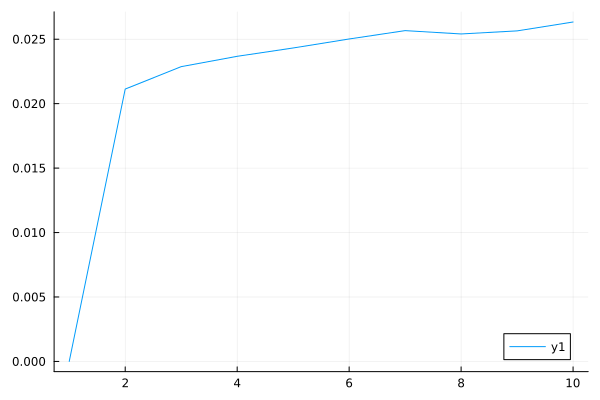

In [208]:
plot(diffusion_over_time)

In [212]:
σs

5.9049174121501685e-5

In [210]:
σxs = σx_fit(sols_with_diffusion)
σys = σy_fit(sols_with_diffusion)
σzs = σz_fit(sols_with_diffusion)
σs = (σxs .* σys .* σzs) .^ (1/3)
plot(total_sats, σs, ylim=(40e-6, 140e-6))

LoadError: Cannot convert Float64 to series data for plotting

In [188]:
Txs = Tx_fit.(sols_with_diffusion)
Tys = Ty_fit.(sols_with_diffusion)
Tzs = Tz_fit.(sols_with_diffusion)
Ts = (Txs .* Tys .* Tzs) .^ (1/3)
plot(total_sats, Ts, ylim=(0, 700e-6))

LoadError: Data contains `Inf` or `NaN` values and a fit cannot be performed

In [189]:
Ts

5-element Vector{Float64}:
 0.0002388256089101157
 0.00018417879216629695
 0.000205878470372997
 0.00026924418170392374
 0.0002741050312174541

## (b)

In [53]:
detunings = [1.68, 3.16, 4.64, 6.12, 7.60, 9.08, 10.56, 12.04, 13.52, 15.00]
@everywhere function update_detuning!(prob, detuning)
    δ1 = +0.00
    δ2 = -1.00
    δ3 = +0.75
    Δ1 = 1e6 * (detuning + δ1) * (2π / Γ)
    Δ2 = 1e6 * (detuning + δ2) * (2π / Γ)
    Δ3 = 1e6 * (detuning + δ3) * (2π / Γ)
    prob.p.ωs[1] = prob.p.ω0s[end] - prob.p.ω0s[1] + Δ1
    prob.p.ωs[2] = prob.p.ω0s[end] - prob.p.ω0s[10] + Δ2
    prob.p.ωs[3] = prob.p.ω0s[end] - prob.p.ω0s[10] + Δ3
    return nothing
end
;

In [54]:
(sols_no_diffusion, sols_with_diffusion, diffusion, diffusion_error, diffusion_over_time) = 
    compute_trajectories_with_diffusion(
    prob_1plus2, prob_func!, prob_1plus2_diffusion, prob_func_diffusion!, n_trajectories1, n_trajectories2, n_trajectories_diffusion, n_times, diffusion_t_end, diffusion_τ_total,
    update_detuning!, detunings
)
;

Progress: 100%|█████████████████████████████████████████| Time: 0:37:01
Progress: 100%|█████████████████████████████████████████| Time: 6:14:57m:36
Progress: 100%|█████████████████████████████████████████| Time: 2:59:32
Progress: 100%|█████████████████████████████████████████| Time: 6:15:50
Progress: 100%|█████████████████████████████████████████| Time: 3:14:46


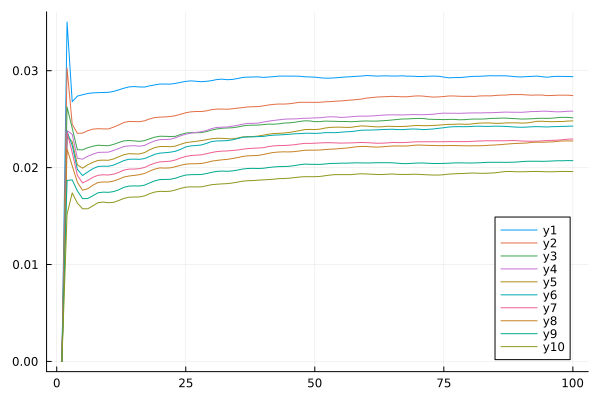

In [57]:
plot(diffusion_over_time)

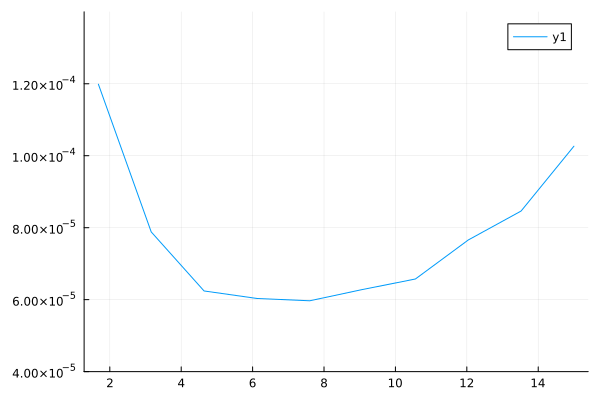

In [59]:
σxs = σx_fit.(sols_with_diffusion)
σys = σy_fit.(sols_with_diffusion)
σzs = σz_fit.(sols_with_diffusion)
σs = (σxs .* σys .* σzs) .^ (1/3)
plot(detunings, σs, ylim=(40e-6, 140e-6))

In [60]:
σs

10-element Vector{Float64}:
 0.00011988005603150527
 7.882251285790051e-5
 6.241630506592609e-5
 6.032761064279177e-5
 5.968793915001627e-5
 6.282395655547311e-5
 6.574450144565045e-5
 7.658359976030114e-5
 8.463088740795053e-5
 0.00010264953783378489

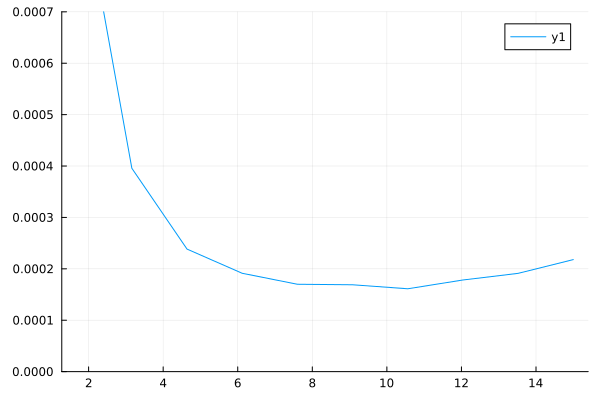

In [61]:
Txs = Tx_fit.(sols_with_diffusion)
Tys = Ty_fit.(sols_with_diffusion)
Tzs = Tz_fit.(sols_with_diffusion)
Ts = (Txs .* Tys .* Tzs) .^ (1/3)
plot(detunings, Ts, ylim=(0, 700e-6))

In [62]:
Ts

10-element Vector{Float64}:
 0.0009913594776639273
 0.000395583603111041
 0.00023833928599509616
 0.00019128027883086047
 0.000169955161381314
 0.0001689448220178511
 0.0001611663346537858
 0.00017826679261438816
 0.00019117885329586503
 0.00021792957095985674

## (c)

In [63]:
δIIas = collect(range(+0.25, -3.25, 15))
@everywhere function update_δIIa!(prob, δIIa)
    detuning = 7.6
    δ2 = δIIa
    Δ2 = 1e6 * (detuning + δ2) * (2π / Γ)
    prob.p.ωs[2] = prob.p.ω0s[end] - prob.p.ω0s[10] + Δ2
    return nothing
end
; 

In [64]:
(sols_no_diffusion, sols_with_diffusion, diffusion, diffusion_error, diffusion_over_time) = 
    compute_trajectories_with_diffusion(
    prob_1plus2, prob_func!, prob_1plus2_diffusion, prob_func_diffusion!, n_trajectories1, n_trajectories2, n_trajectories_diffusion, n_times, diffusion_t_end, diffusion_τ_total,
    update_δIIa!, δIIas
)
;

Progress: 100%|█████████████████████████████████████████| Time: 0:54:39
Progress: 100%|█████████████████████████████████████████| Time: 9:14:24m41
Progress: 100%|█████████████████████████████████████████| Time: 4:31:22
Progress: 100%|█████████████████████████████████████████| Time: 8:50:15m
Progress: 100%|█████████████████████████████████████████| Time: 4:44:21


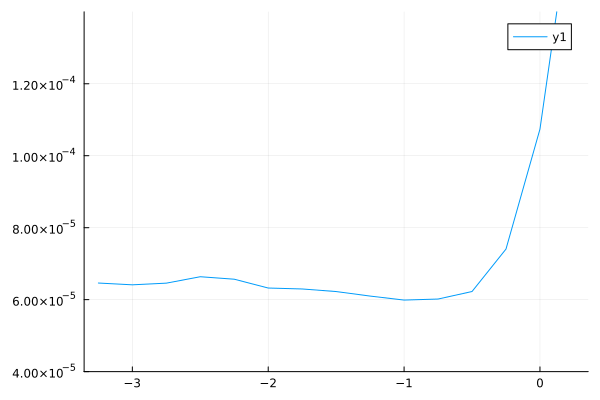

In [69]:
σxs = σx_fit.(sols_with_diffusion)
σys = σy_fit.(sols_with_diffusion)
σzs = σz_fit.(sols_with_diffusion)
σs = (σxs .* σys .* σzs) .^ (1/3)
plot(δIIas, (σxs .* σys .* σzs) .^ (1/3), ylim=(40e-6, 140e-6))

In [70]:
σs

15-element Vector{Float64}:
 0.00017321060325200773
 0.00010738998805188012
 7.405926817644709e-5
 6.226173236875769e-5
 6.016894442149581e-5
 5.988398192107717e-5
 6.09948387477598e-5
 6.2251764538154e-5
 6.29688223781007e-5
 6.323097787495827e-5
 6.568274193722807e-5
 6.637192327060502e-5
 6.458631658485089e-5
 6.41233487927963e-5
 6.461972019230882e-5

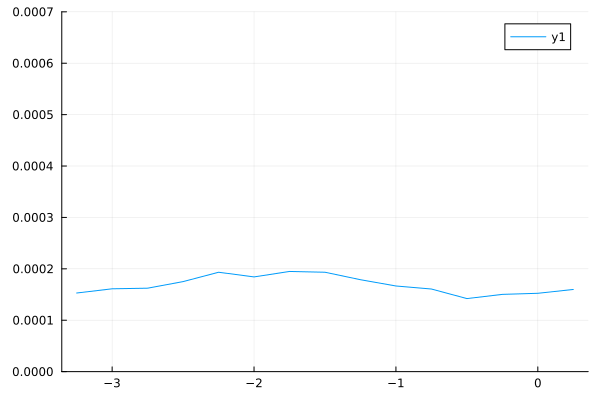

In [68]:
Txs = Tx_fit.(sols_with_diffusion)
Tys = Ty_fit.(sols_with_diffusion)
Tzs = Tz_fit.(sols_with_diffusion)
Ts = (Txs .* Tys .* Tzs) .^ (1/3)
plot(δIIas, (Txs .* Tys .* Tzs) .^ (1/3), ylim=(0,700e-6))

In [71]:
Ts

15-element Vector{Float64}:
 0.00015985577394579862
 0.0001523745420871387
 0.00015026996475827088
 0.0001420926867340153
 0.00016070222819407587
 0.00016659279208645165
 0.00017879249142172782
 0.00019332750824337862
 0.00019486599203985506
 0.00018424359968492295
 0.00019330338560488163
 0.00017511977371729388
 0.00016230023160052355
 0.00016111953370618812
 0.0001529185934626929

## (d)

In [81]:
collect(δIIbs)

15-element Vector{Float64}:
 -0.75
 -0.5357142857142857
 -0.32142857142857145
 -0.10714285714285714
  0.10714285714285714
  0.32142857142857145
  0.5357142857142857
  0.75
  0.9642857142857143
  1.1785714285714286
  1.3928571428571428
  1.6071428571428572
  1.8214285714285714
  2.0357142857142856
  2.25

In [10]:
# δIIbs = range(-0.75, 2.25, 15)
δIIbs = [2.25]
@everywhere function update_δIIb!(prob, δIIb)
    detuning = 7.6
    δ3 = δIIb
    Δ3 = 1e6 * (detuning + δ3) * (2π / Γ)
    prob.p.ωs[3] = prob.p.ω0s[end] - prob.p.ω0s[10] + Δ3
    return nothing
end
; 

In [11]:
(sols_no_diffusion, sols_with_diffusion, diffusion, diffusion_error, diffusion_over_time) = 
    compute_trajectories_with_diffusion(
    prob_1plus2, prob_func!, prob_1plus2_diffusion, prob_func_diffusion!, n_trajectories1, n_trajectories2, n_trajectories_diffusion, n_times, diffusion_t_end, diffusion_τ_total,
    update_δIIb!, δIIbs
)
;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:46
Progress: 100%|█████████████████████████████████████████| Time: 0:03:46m03m
Progress: 100%|█████████████████████████████████████████| Time: 0:01:55
Progress: 100%|█████████████████████████████████████████| Time: 0:03:35
Progress: 100%|█████████████████████████████████████████| Time: 0:01:55


In [17]:
σxs = σx_fit.(sols_with_diffusion)
σys = σy_fit.(sols_with_diffusion)
σzs = σz_fit.(sols_with_diffusion)
σs = (σxs .* σys .* σzs) .^ (1/3)
plot(δIIbs, (σxs .* σys .* σzs) .^ (1/3), ylim=(40e-6,140e-6))

LoadError: Data contains `Inf` or `NaN` values and a fit cannot be performed

In [21]:
σs

7.103561716153844e-5

In [23]:
Txs = Tx_fit(sols_with_diffusion)
Tys = Ty_fit(sols_with_diffusion)
Tzs = Tz_fit(sols_with_diffusion)
Ts = (Txs .* Tys .* Tzs) .^ (1/3)
plot(δIIbs, (Txs .* Tys .* Tzs) .^ (1/3), ylim=(0,700e-6))

LoadError: Cannot convert Float64 to series data for plotting

In [24]:
Ts

0.00023016051584819508

## (e)

In [190]:
B_div_C = 0.37/0.28
A_div_BC = [0, 0.37, 1.25, 2.60, 4.5, 7.0, 9.6, 12.6, 15.0, 18.3, 20.9, 22.9]
A_div_BC = A_div_BC ./ (31.4 .- A_div_BC)
A_div_C = A_div_BC .* (1 .+ B_div_C)
C_div_ABC = (A_div_C .+ B_div_C .+ 1).^(-1)
A_div_ABC = A_div_C .* C_div_ABC
B_div_ABC = B_div_C .* C_div_ABC
;

In [191]:
# all_params = [1300]
# B_div_C = 0.37/0.28
# A_div_C = (1.2 .* all_params / 1100)
# C_div_ABC = (A_div_C .+ B_div_C .+ 1).^(-1)
# A_div_ABC = A_div_C .* C_div_ABC
# B_div_ABC = B_div_C .* C_div_ABC
# ;

In [192]:
# Calculate the saturation parameters for IIa and IIb for a range of saturation ratios
sat_ratios = zip(B_div_ABC, C_div_ABC, A_div_ABC)

@everywhere function update_sat_ratios!(prob, sat_ratios)
    I_sat_ratio, IIa_sat_ratio, IIb_sat_ratio = sat_ratios
    prob.p.sim_params.s1_ratio = I_sat_ratio
    prob.p.sim_params.s2_ratio = IIa_sat_ratio
    prob.p.sim_params.s3_ratio = IIb_sat_ratio
    return nothing
end

# II_total_sat = sats[2] + sats[3]
# IIab_sats = zip(IIa_sat_ratios .* II_total_sat, IIb_sat_ratios .* II_total_sat)
; 

In [193]:
I_sat_ratio, IIa_sat_ratio, IIb_sat_ratio = first(sat_ratios)

(0.5692307692307692, 0.4307692307692308, 0.0)

In [194]:
(sols_no_diffusion, sols_with_diffusion, diffusion, diffusion_error, diffusion_over_time) = 
    compute_trajectories_with_diffusion(
    prob_1plus2, prob_func!, prob_1plus2_diffusion, prob_func_diffusion!, n_trajectories1, n_trajectories2, n_trajectories_diffusion, n_times, diffusion_t_end, diffusion_τ_total,
    update_sat_ratios!, sat_ratios
)
;

Progress: 100%|█████████████████████████████████████████| Time: 0:05:18
Progress: 100%|█████████████████████████████████████████| Time: 0:47:29m00
Progress: 100%|█████████████████████████████████████████| Time: 0:27:15
Progress: 100%|█████████████████████████████████████████| Time: 0:44:01
Progress: 100%|█████████████████████████████████████████| Time: 0:26:59


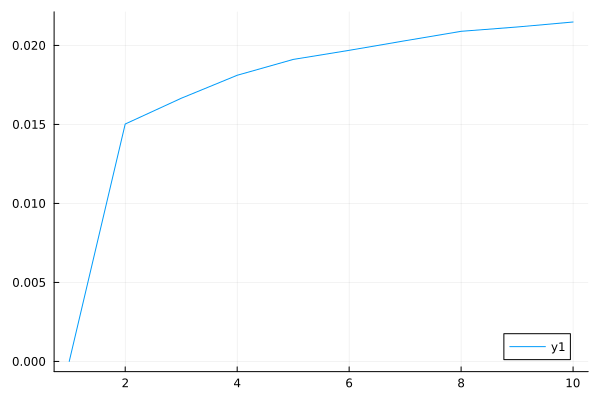

In [153]:
plot(diffusion_over_time)

In [203]:
σs

12-element Vector{Float64}:
 0.00018492966178179513
 0.00011929558052647921
 7.566823799046191e-5
 6.100298508960273e-5
 5.551101219434756e-5
 5.799689635358377e-5
 5.936167838240508e-5
 5.979491743178099e-5
 6.374022239933176e-5
 6.855162729474784e-5
 7.839333817605532e-5
 8.810083184975604e-5

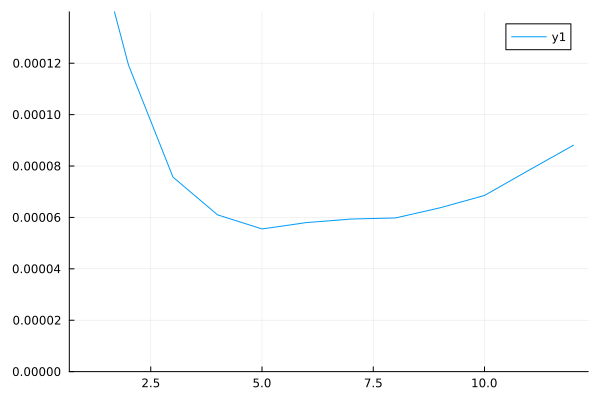

In [202]:
σxs = σx_fit.(sols_with_diffusion)
σys = σy_fit.(sols_with_diffusion)
σzs = σz_fit.(sols_with_diffusion)
σs = (σxs .* σys .* σzs) .^ (1/3)
plot((σxs .* σys .* σzs) .^ (1/3), ylim=(0,140e-6))

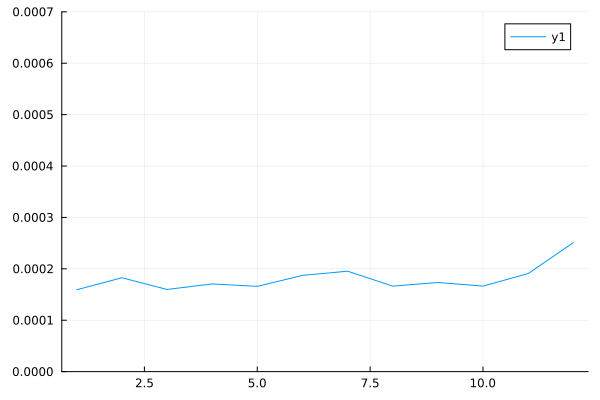

In [201]:
Txs = Tx_fit.(sols_with_diffusion)
Tys = Ty_fit.(sols_with_diffusion)
Tzs = Tz_fit.(sols_with_diffusion)
Ts = (Txs .* Tys .* Tzs) .^ (1/3)
plot((Txs .* Tys .* Tzs) .^ (1/3), ylim=(0,700e-6))

In [22]:
Ts

12-element Vector{Float64}:
 0.00015329051806780344
 0.00016270830437951385
 0.0001490166825754547
 0.00014871864692124782
 0.00015703085680570267
 0.00015241660624928845
 0.00014686860954845848
 0.00017140687918841888
 0.00016579094048937043
 0.0001879359541159818
 0.0001975588579249895
 0.0002427728453816075

# Figure 3

In [44]:
(sols_no_diffusion, sols_with_diffusion, diffusion, diffusion_error, diffusion_over_time) = 
    compute_trajectories_with_diffusion(
    prob_1plus2, prob_func!, prob_1plus2_diffusion, prob_func_diffusion!, n_trajectories1, n_trajectories2, n_trajectories_diffusion, n_times, diffusion_t_end, diffusion_τ_total
)
;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:41
Progress: 100%|█████████████████████████████████████████| Time: 0:11:09m
Progress: 100%|█████████████████████████████████████████| Time: 0:03:24
Progress: 100%|█████████████████████████████████████████| Time: 0:11:51
Progress: 100%|█████████████████████████████████████████| Time: 0:03:26


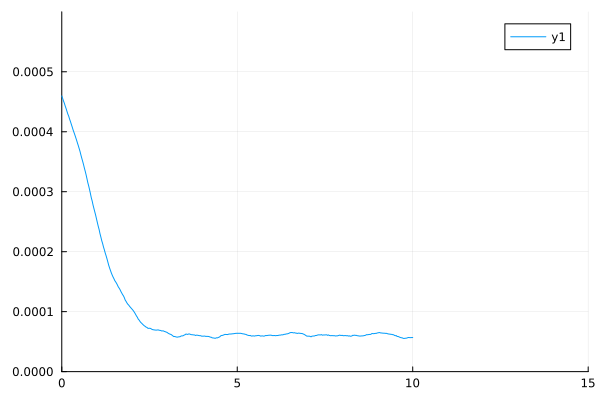

In [45]:
σs = []
for i ∈ 40:444
    σ = σ_geom_ensemble_sol(sols_with_diffusion, i)
    push!(σs, σ)
end
times = range(0,10,length(σs))

densities = density_vs_time(sols_with_diffusion)[40:end]

plot(times, σs, xlim=(0,15), ylim=(0, 600e-6))

In [49]:
io = open("sizes_3freq.txt", "w") do io
    for x in σs
        println(io, x)
    end
end

io = open("times_3freq.txt", "w") do io
    for x in times
        println(io, x)
    end
end

io = open("densities_3freq.txt", "w") do io
    for x in densities
        println(io, x)
    end
end

In [ ]:
(sols_no_diffusion, sols_with_diffusion, diffusion, diffusion_error, diffusion_over_time) = 
    compute_trajectories_with_diffusion(
    prob_1plus1, prob_func!, prob_1plus1_diffusion, prob_func_diffusion!, n_trajectories1, n_trajectories2, n_trajectories_diffusion, n_times, diffusion_t_end, diffusion_τ_total
)
;

Progress:  18%|████████                                 |  ETA: 0:06:27

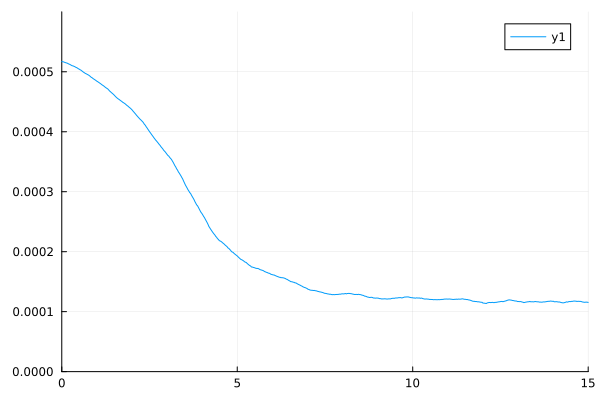

In [254]:
σs = []
for i ∈ 40:645
    σ = σ_geom_ensemble_sol(sols_with_diffusion, i)
    push!(σs, σ)
end
times = range(0,15,length(σs))

densities = density_vs_time(sols_with_diffusion)[40:end]

plot(times, σs, xlim=(0,15), ylim=(0, 600e-6))

In [255]:
io = open("sizes_2freq.txt", "w") do io
    for x in σs
        println(io, x)
    end
end

io = open("times_2freq.txt", "w") do io
    for x in times
        println(io, x)
    end
end

io = open("densities_2freq.txt", "w") do io
    for x in densities
        println(io, x)
    end
end

# Figure 4

In [175]:
include("compute_size_temperature.jl")

In [176]:
prob_1plus2.p.sim_params.s_factor_start = 0.9
prob_1plus2.p.sim_params.s_factor_end = 0.7
;

In [177]:
# n_trajectories1 = 100
# n_trajectories2 = 500
# n_trajectories_diffusion = 100000
n_trajectories1 = 50
n_trajectories2 = 200
n_trajectories_diffusion = 50000
n_times = 10
diffusion_t_end = 20e-6
diffusion_τ_total = 20e-6
;

In [178]:
B_grads = [25] #25:25:175
@everywhere function update_B_grad!(prob, B_grad)
    prob.p.sim_params.B_grad_end = B_grad
    return nothing
end
; 

In [179]:
(sols_no_diffusion, sols_with_diffusion, diffusion, diffusion_error, diffusion_over_time) = 
    compute_trajectories_with_diffusion(
    prob_1plus2, prob_func!, prob_1plus2_diffusion, prob_func_diffusion!, n_trajectories1, n_trajectories2, n_trajectories_diffusion, n_times, diffusion_t_end, diffusion_τ_total,
    update_B_grad!, B_grads
)
;

Progress: 100%|█████████████████████████████████████████| Time: 0:02:13
Progress: 100%|█████████████████████████████████████████| Time: 0:39:12:00
Progress: 100%|█████████████████████████████████████████| Time: 0:09:21
Progress: 100%|█████████████████████████████████████████| Time: 0:38:53
Progress: 100%|█████████████████████████████████████████| Time: 0:09:25


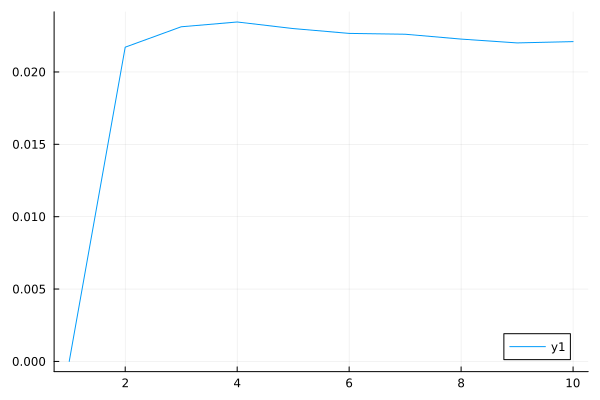

In [180]:
plot(diffusion_over_time)

In [181]:
σs

0.00014537745756582713

In [182]:
σxs = σx_fit(sols_with_diffusion)
σys = σy_fit(sols_with_diffusion)
σzs = σz_fit(sols_with_diffusion)
σs = (σxs .* σys .* σzs) .^ (1/3)
plot(B_grads, σs, ylim=(0e-6,140e-6))

LoadError: Cannot convert Float64 to series data for plotting